In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, Model
from keras.layers import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout
from keras.layers import add, dot, concatenate
from keras.layers import LSTM

In [4]:
with open('train_qa.txt', 'rb') as f:
  train_data = pickle.load(f)

In [5]:
with open('test_qa.txt', 'rb') as f:
  test_data = pickle.load(f)

In [6]:
print(len(train_data), len(test_data))

10000 1000


In [7]:
#Checking data
for i in range(5):
  print(" ".join(train_data[i][0]), " ".join(train_data[i][1]), "".join(train_data[i][2]))

Mary moved to the bathroom . Sandra journeyed to the bedroom . Is Sandra in the hallway ? no
Mary moved to the bathroom . Sandra journeyed to the bedroom . Mary went back to the bedroom . Daniel went back to the hallway . Is Daniel in the bathroom ? no
Mary moved to the bathroom . Sandra journeyed to the bedroom . Mary went back to the bedroom . Daniel went back to the hallway . Sandra went to the kitchen . Daniel went back to the bathroom . Is Daniel in the office ? no
Mary moved to the bathroom . Sandra journeyed to the bedroom . Mary went back to the bedroom . Daniel went back to the hallway . Sandra went to the kitchen . Daniel went back to the bathroom . Daniel picked up the football there . Daniel went to the bedroom . Is Daniel in the bedroom ? yes
Mary moved to the bathroom . Sandra journeyed to the bedroom . Mary went back to the bedroom . Daniel went back to the hallway . Sandra went to the kitchen . Daniel went back to the bathroom . Daniel picked up the football there . Dan

In [8]:
vocab = set()
all_data = test_data + train_data

In [9]:
for story, question , answer in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))

In [10]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went'}

In [11]:
"yes" in vocab

False

In [12]:
"no" in vocab

False

In [13]:
vocab.add("yes")
vocab.add("no")

In [14]:
vocab_len = len(vocab) + 1 #extra space to hold a 0 for Keras's pad_sequences

In [15]:
max_story_len = max([len(data[0]) for data in all_data])

In [16]:
max_question_len = max([len(data[1]) for data in all_data])

In [17]:
print(max_story_len, max_question_len)

156 6


In [18]:
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

In [19]:
tokenizer.word_index

{'mary': 1,
 'picked': 2,
 'milk': 3,
 'john': 4,
 'took': 5,
 'football': 6,
 'bedroom': 7,
 'apple': 8,
 'yes': 9,
 'sandra': 10,
 'kitchen': 11,
 'bathroom': 12,
 '.': 13,
 'put': 14,
 'journeyed': 15,
 'the': 16,
 '?': 17,
 'there': 18,
 'got': 19,
 'went': 20,
 'discarded': 21,
 'hallway': 22,
 'left': 23,
 'grabbed': 24,
 'down': 25,
 'in': 26,
 'dropped': 27,
 'moved': 28,
 'garden': 29,
 'daniel': 30,
 'up': 31,
 'no': 32,
 'travelled': 33,
 'office': 34,
 'to': 35,
 'back': 36,
 'is': 37}

In [20]:
def vectorize_stories(data, word_index=tokenizer.word_index, max_story_len=max_story_len,max_question_len=max_question_len):
    # X = STORIES
    X = []
    # Xq = QUERY/QUESTION
    Xq = []
    # Y = CORRECT ANSWER
    Y = []

    for story, query, answer in data:
        # Grab the word index for every word in story
        x = [word_index[word.lower()] for word in story]
        # Grab the word index for every word in query
        xq = [word_index[word.lower()] for word in query]
        # Grab the Answers (either Yes/No so we don't need to use list comprehension here)
        # Index 0 is reserved so we're going to use + 1
        y = np.zeros(len(word_index) + 1)
        # Now that y is all zeros and we know its just Yes/No , we can use numpy logic to create this assignment
        y[word_index[answer]] = 1
        # Append each set of story,query, and answer to their respective holding lists
        X.append(x)
        Xq.append(xq)
        Y.append(y)

    # Finally, pad the sequences based on their max length so the RNN can be trained on uniformly long sequences.
    return (pad_sequences(X, maxlen=max_story_len),pad_sequences(Xq, maxlen=max_question_len), np.array(Y))

In [21]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data)
inputs_test, queries_test, answers_test = vectorize_stories(test_data)

In [22]:
inputs_test

array([[ 0,  0,  0, ..., 16,  7, 13],
       [ 0,  0,  0, ..., 16, 29, 13],
       [ 0,  0,  0, ..., 16, 29, 13],
       ...,
       [ 0,  0,  0, ..., 16,  8, 13],
       [ 0,  0,  0, ..., 16, 29, 13],
       [ 0,  0,  0, ...,  8, 18, 13]], dtype=int32)

In [23]:
tokenizer.word_index['yes']

9

In [24]:
tokenizer.word_index['no']

32

In [25]:
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))

In [26]:
#Input encoder m
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_len,output_dim=64))
input_encoder_m.add(Dropout(0.3))

In [27]:
#Input encoder c
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_len,output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))

In [28]:
#Question encoder
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_len,
                               output_dim=64,
                               input_length=max_question_len))
question_encoder.add(Dropout(0.3))

In [29]:
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

In [30]:
match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)

In [31]:
response = add([match, input_encoded_c])
response = Permute((2, 1))(response)

In [32]:
answer = concatenate([response, question_encoded])

In [33]:
answer = LSTM(32)(answer)
answer = Dropout(0.5)(answer)
answer = Dense(vocab_len)(answer)

In [34]:
answer = Activation('softmax')(answer)

# build the final model
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 156)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 6)]                  0         []                            
                                                                                                  
 sequential (Sequential)     (None, None, 64)             2432      ['input_1[0][0]']             
                                                                                                  
 sequential_2 (Sequential)   (None, 6, 64)                2432      ['input_2[0][0]']             
                                                                                              

In [36]:
history = model.fit([inputs_train, queries_train], answers_train,batch_size=32,epochs=100,validation_data=([inputs_test, queries_test], answers_test))

Epoch 1/100
313/313 [==============================] - 9s 13ms/step - loss: 0.9000 - accuracy: 0.5099 - val_loss: 0.7032 - val_accuracy: 0.5030
Epoch 2/100
313/313 [==============================] - 2s 7ms/step - loss: 0.7124 - accuracy: 0.5015 - val_loss: 0.6936 - val_accuracy: 0.5030
Epoch 3/100
313/313 [==============================] - 2s 6ms/step - loss: 0.6996 - accuracy: 0.4987 - val_loss: 0.6934 - val_accuracy: 0.4970
Epoch 4/100
313/313 [==============================] - 2s 6ms/step - loss: 0.6971 - accuracy: 0.5019 - val_loss: 0.6934 - val_accuracy: 0.5030
Epoch 5/100
313/313 [==============================] - 2s 6ms/step - loss: 0.6960 - accuracy: 0.4999 - val_loss: 0.6936 - val_accuracy: 0.5030
Epoch 6/100
313/313 [==============================] - 2s 7ms/step - loss: 0.6960 - accuracy: 0.4938 - val_loss: 0.6950 - val_accuracy: 0.5030
Epoch 7/100
313/313 [==============================] - 3s 8ms/step - loss: 0.6960 - accuracy: 0.4950 - val_loss: 0.6932 - val_accuracy: 0.497

In [37]:
filename = 'QAchatbot'
model.save(filename)

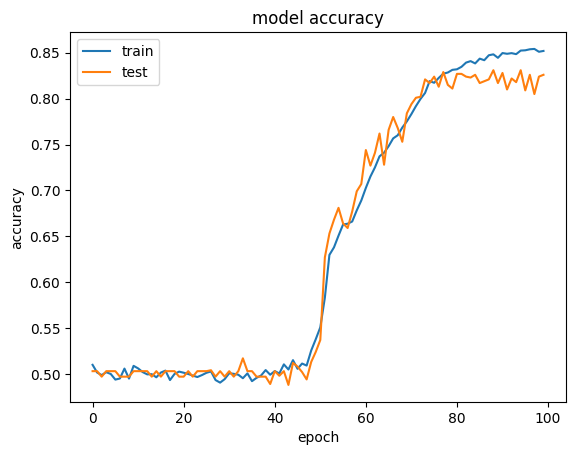

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [39]:
model.load_weights(filename)
pred_results = model.predict(([inputs_test, queries_test]))

32/32 [==============================] - 0s 2ms/step


In [40]:
story =' '.join(word for word in test_data[0][0])
print(story)
query = ' '.join(word for word in test_data[0][1])
print(query)

Mary got the milk there . John moved to the bedroom .
Is John in the kitchen ?


In [41]:
print("Answer from Data is:",test_data[0][2])

Answer from Data is: no


In [42]:
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  no
Probability of certainty was:  0.9810791


In [43]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [44]:
my_story = "John left the kitchen . Sandra dropped the football in the garden ."
my_story.split()
my_question = "Is the football in the garden ?"
my_question.split()

['Is', 'the', 'football', 'in', 'the', 'garden', '?']

In [45]:
mydata = [(my_story.split(),my_question.split(),'yes')]
my_story,my_ques,my_ans = vectorize_stories(mydata)
pred_results = model.predict(([ my_story, my_ques]))

1/1 [==============================] - 0s 79ms/step


In [46]:
#Using it on my data
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  yes
Probability of certainty was:  0.9777002
